# Xenium + Squidpy quickstart

This notebook loads the Xenium export in this folder and walks through a typical Squidpy/Scanpy workflow: QC, clustering, marker-driven cell annotation, spatial neighborhood statistics, and cell-cell interaction analyses.

In [1]:
# If dependencies are missing, uncomment the next line (requires internet access)
!pip install --quiet "scanpy>=1.9" "squidpy>=1.3" "geopandas" "omnipath"


In [2]:
import json
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

warnings.filterwarnings("ignore", category=UserWarning)
sc.settings.set_figure_params(dpi=120, facecolor="white")
sc.settings.verbosity = 2

DATA_DIR = Path(".")
LIB_ID = "block26_slide1_reg1"  # used for spatial metadata
N_SUBSAMPLE = None  # set e.g. to 60000 for faster interactive runs on large data
np.random.seed(0)


/data1/project/atwoddl/Anaconda3/envs/xenium/lib/python3.9/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/data1/project/atwoddl/Anaconda3/envs/xenium/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [3]:
# Quick file presence check
expected = [
    "cells.parquet",
    "cell_feature_matrix",
    "cell_feature_matrix.h5",
    "transcripts.parquet",
    "cell_boundaries.parquet",
    "nucleus_boundaries.parquet",
    "morphology.ome.tif",
    "experiment.xenium",
]
for fname in expected:
    print(f"{fname:35s} exists={ (DATA_DIR / fname).exists() }")


cells.parquet                       exists=True
cell_feature_matrix                 exists=True
cell_feature_matrix.h5              exists=True
transcripts.parquet                 exists=True
cell_boundaries.parquet             exists=True
nucleus_boundaries.parquet          exists=True
morphology.ome.tif                  exists=True
experiment.xenium                   exists=True


In [4]:
# Experiment-level metadata
with open(DATA_DIR / "experiment.xenium") as f:
    exp_meta = json.load(f)
pd.Series(exp_meta, name="experiment")


major_version                                                                                    5
minor_version                                                                                    2
patch_version                                                                                    0
run_name                                                                                 ARPA_TNBC
run_start_time                                                                2025-02-28T07:30:33Z
region_name                                                                    block26_slide1_reg1
preservation_method                                                                           ffpe
num_cells                                                                                   367141
transcripts_per_cell                                                                           176
transcripts_per_100um                                                                   437.741238
region_are

In [5]:
def load_xenium(base_dir: Path, library_id: str):
    """Load Xenium counts + metadata, preferring sq.read.xenium when available.

    Falls back to scanpy.read_10x_mtx with centroids as spatial coordinates.
    """
    try:
        adata = sq.read.xenium(path=base_dir, library_id=library_id)
        adata.var_names_make_unique()
        adata.layers["counts"] = adata.X.copy()
        adata.obs["library_id"] = library_id
        print(f"Loaded with sq.read.xenium: {adata.shape}")
        return adata
    except Exception as e:
        print("sq.read.xenium not available, falling back. Reason:", e)
        counts_path = base_dir / "cell_feature_matrix"
        adata = sc.read_10x_mtx(counts_path, var_names="gene_symbols", make_unique=True)
        cells = pd.read_parquet(base_dir / "cells.parquet").set_index("cell_id")
        common = adata.obs_names.intersection(cells.index)
        adata = adata[common].copy()
        adata.obs = cells.loc[common]
        adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].to_numpy()
        adata.obs["library_id"] = library_id
        adata.layers["counts"] = adata.X.copy()
        adata.uns.setdefault("spatial", {})[library_id] = {
            "metadata": {"coordinate_system": "xenium"},
            "scalefactors": {"spot_diameter_fullres": 1.0},
        }
        print(f"Loaded via fallback: {adata.shape}")
        return adata

adata = load_xenium(DATA_DIR, library_id=LIB_ID)
adata


sq.read.xenium not available, falling back. Reason: module 'squidpy.read' has no attribute 'xenium'
Loaded via fallback: (367141, 5001)


AnnData object with n_obs × n_vars = 367141 × 5001
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'library_id'
    var: 'gene_ids', 'feature_types'
    uns: 'spatial'
    obsm: 'spatial'
    layers: 'counts'

In [6]:
# QC metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)
qc_summary = adata.obs[["total_counts", "n_genes_by_counts"]].describe(percentiles=[0.5, 0.9, 0.99]).T
qc_summary


,count,mean,std,min,50%,90%,99%,max
total_counts,367141.0,312.990021,391.522675,0.0,175.0,758.0,1895.0,7573.0
n_genes_by_counts,367141.0,225.193212,224.221569,0.0,148.0,532.0,1023.0,1998.0


In [7]:
# Basic filtering thresholds (tune as needed)
min_counts = 30
min_genes = 10
max_counts = float(np.quantile(adata.obs["total_counts"], 0.99) * 4)

adata = adata[(adata.obs["total_counts"] > min_counts) &
              (adata.obs["total_counts"] < max_counts) &
              (adata.obs["n_genes_by_counts"] > min_genes)].copy()
sc.pp.filter_genes(adata, min_cells=30)
print(adata)


filtered out 1 genes that are detected in less than 30 cells
AnnData object with n_obs × n_vars = 330967 × 5000
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'library_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'
    layers: 'counts'


In [8]:
# Optional downsample for speed on very large data
if N_SUBSAMPLE is not None and N_SUBSAMPLE < adata.n_obs:
    sc.pp.subsample(adata, n_obs=N_SUBSAMPLE, random_state=0)
    print(f"Subsampled to {adata.n_obs} cells for faster iteration")


In [15]:
!pip install --user scikit-misc

In [17]:
# Normalize, log, HVGs, PCA
if "counts" not in adata.layers:
    adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# seurat_v3 needs scikit-misc; fall back if unavailable
try:
    sc.pp.highly_variable_genes(
        adata, flavor="seurat_v3", n_top_genes=4000, subset=True
    )
except ImportError:
    print("scikit-misc missing; using flavor='seurat' instead.")
    sc.pp.highly_variable_genes(
        adata, flavor="seurat", n_top_genes=4000, subset=True
    )

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=50, svd_solver="arpack")


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
scikit-misc missing; using flavor='seurat' instead.
extracting highly variable genes
    finished (0:00:01)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:39)


computing neighbors
    using 'X_pca' with n_pcs = 30


/data1/project/atwoddl/Anaconda3/envs/xenium/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished (0:01:15)
computing UMAP
    finished (0:05:08)
running Leiden clustering


/tmp/ipykernel_2104811/1723001962.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0, key_added="leiden_1")


    finished (0:13:49)


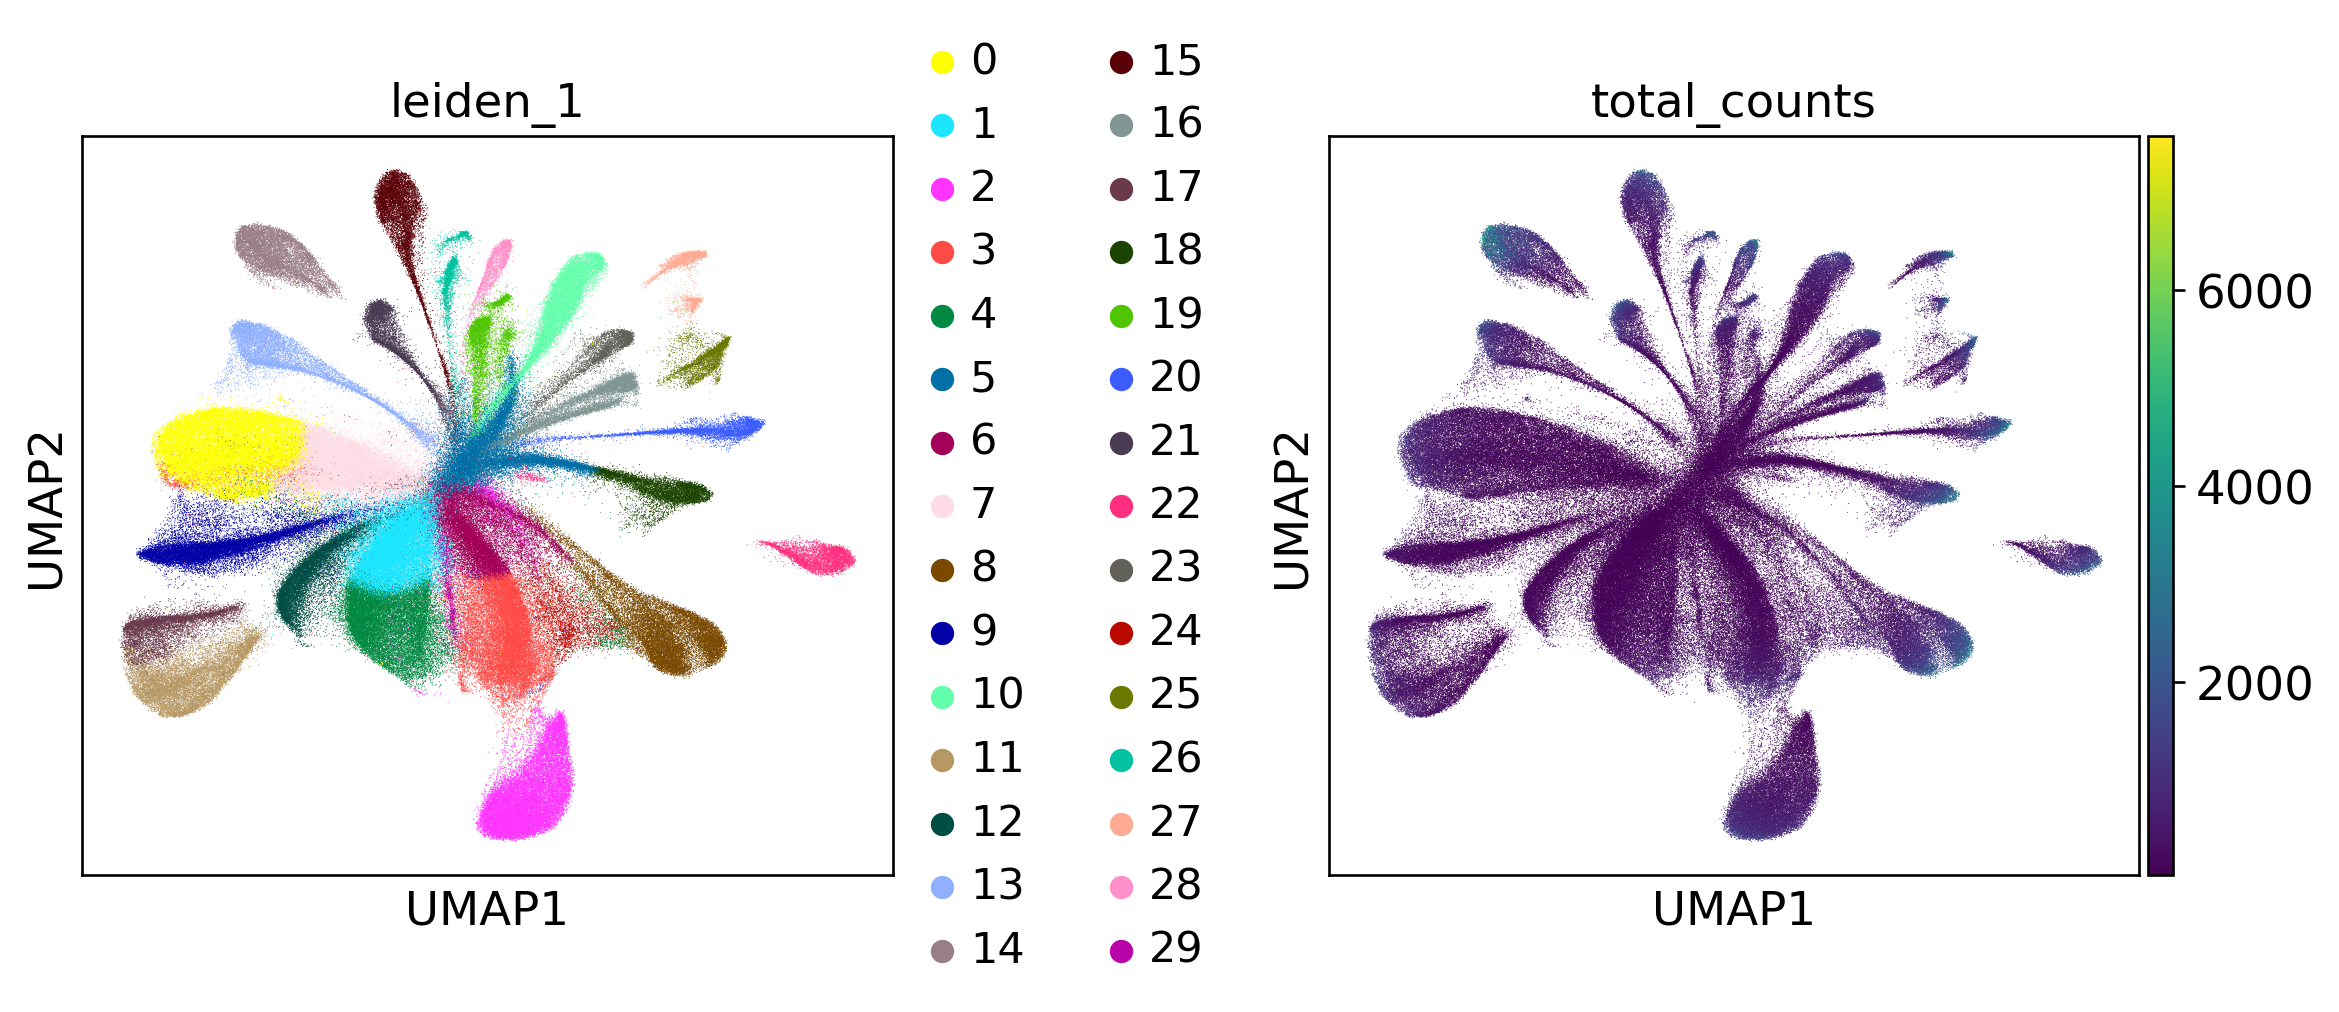

In [18]:
# Neighborhood graph, clustering, embedding
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30, metric="cosine")
sc.tl.umap(adata, min_dist=0.3, spread=1.0)
sc.tl.leiden(adata, resolution=1.0, key_added="leiden_1")
sc.pl.umap(adata, color=["leiden_1", "total_counts"], wspace=0.4)


ranking genes
    finished (0:08:35)


/data1/project/atwoddl/Anaconda3/envs/xenium/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/data1/project/atwoddl/Anaconda3/envs/xenium/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/data1/project/atwoddl/Anaconda3/envs/xenium/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/data1/project/atwoddl/Anaconda3/envs/xenium/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/data1/project/atwoddl/Anaconda3/envs/xenium/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: inv

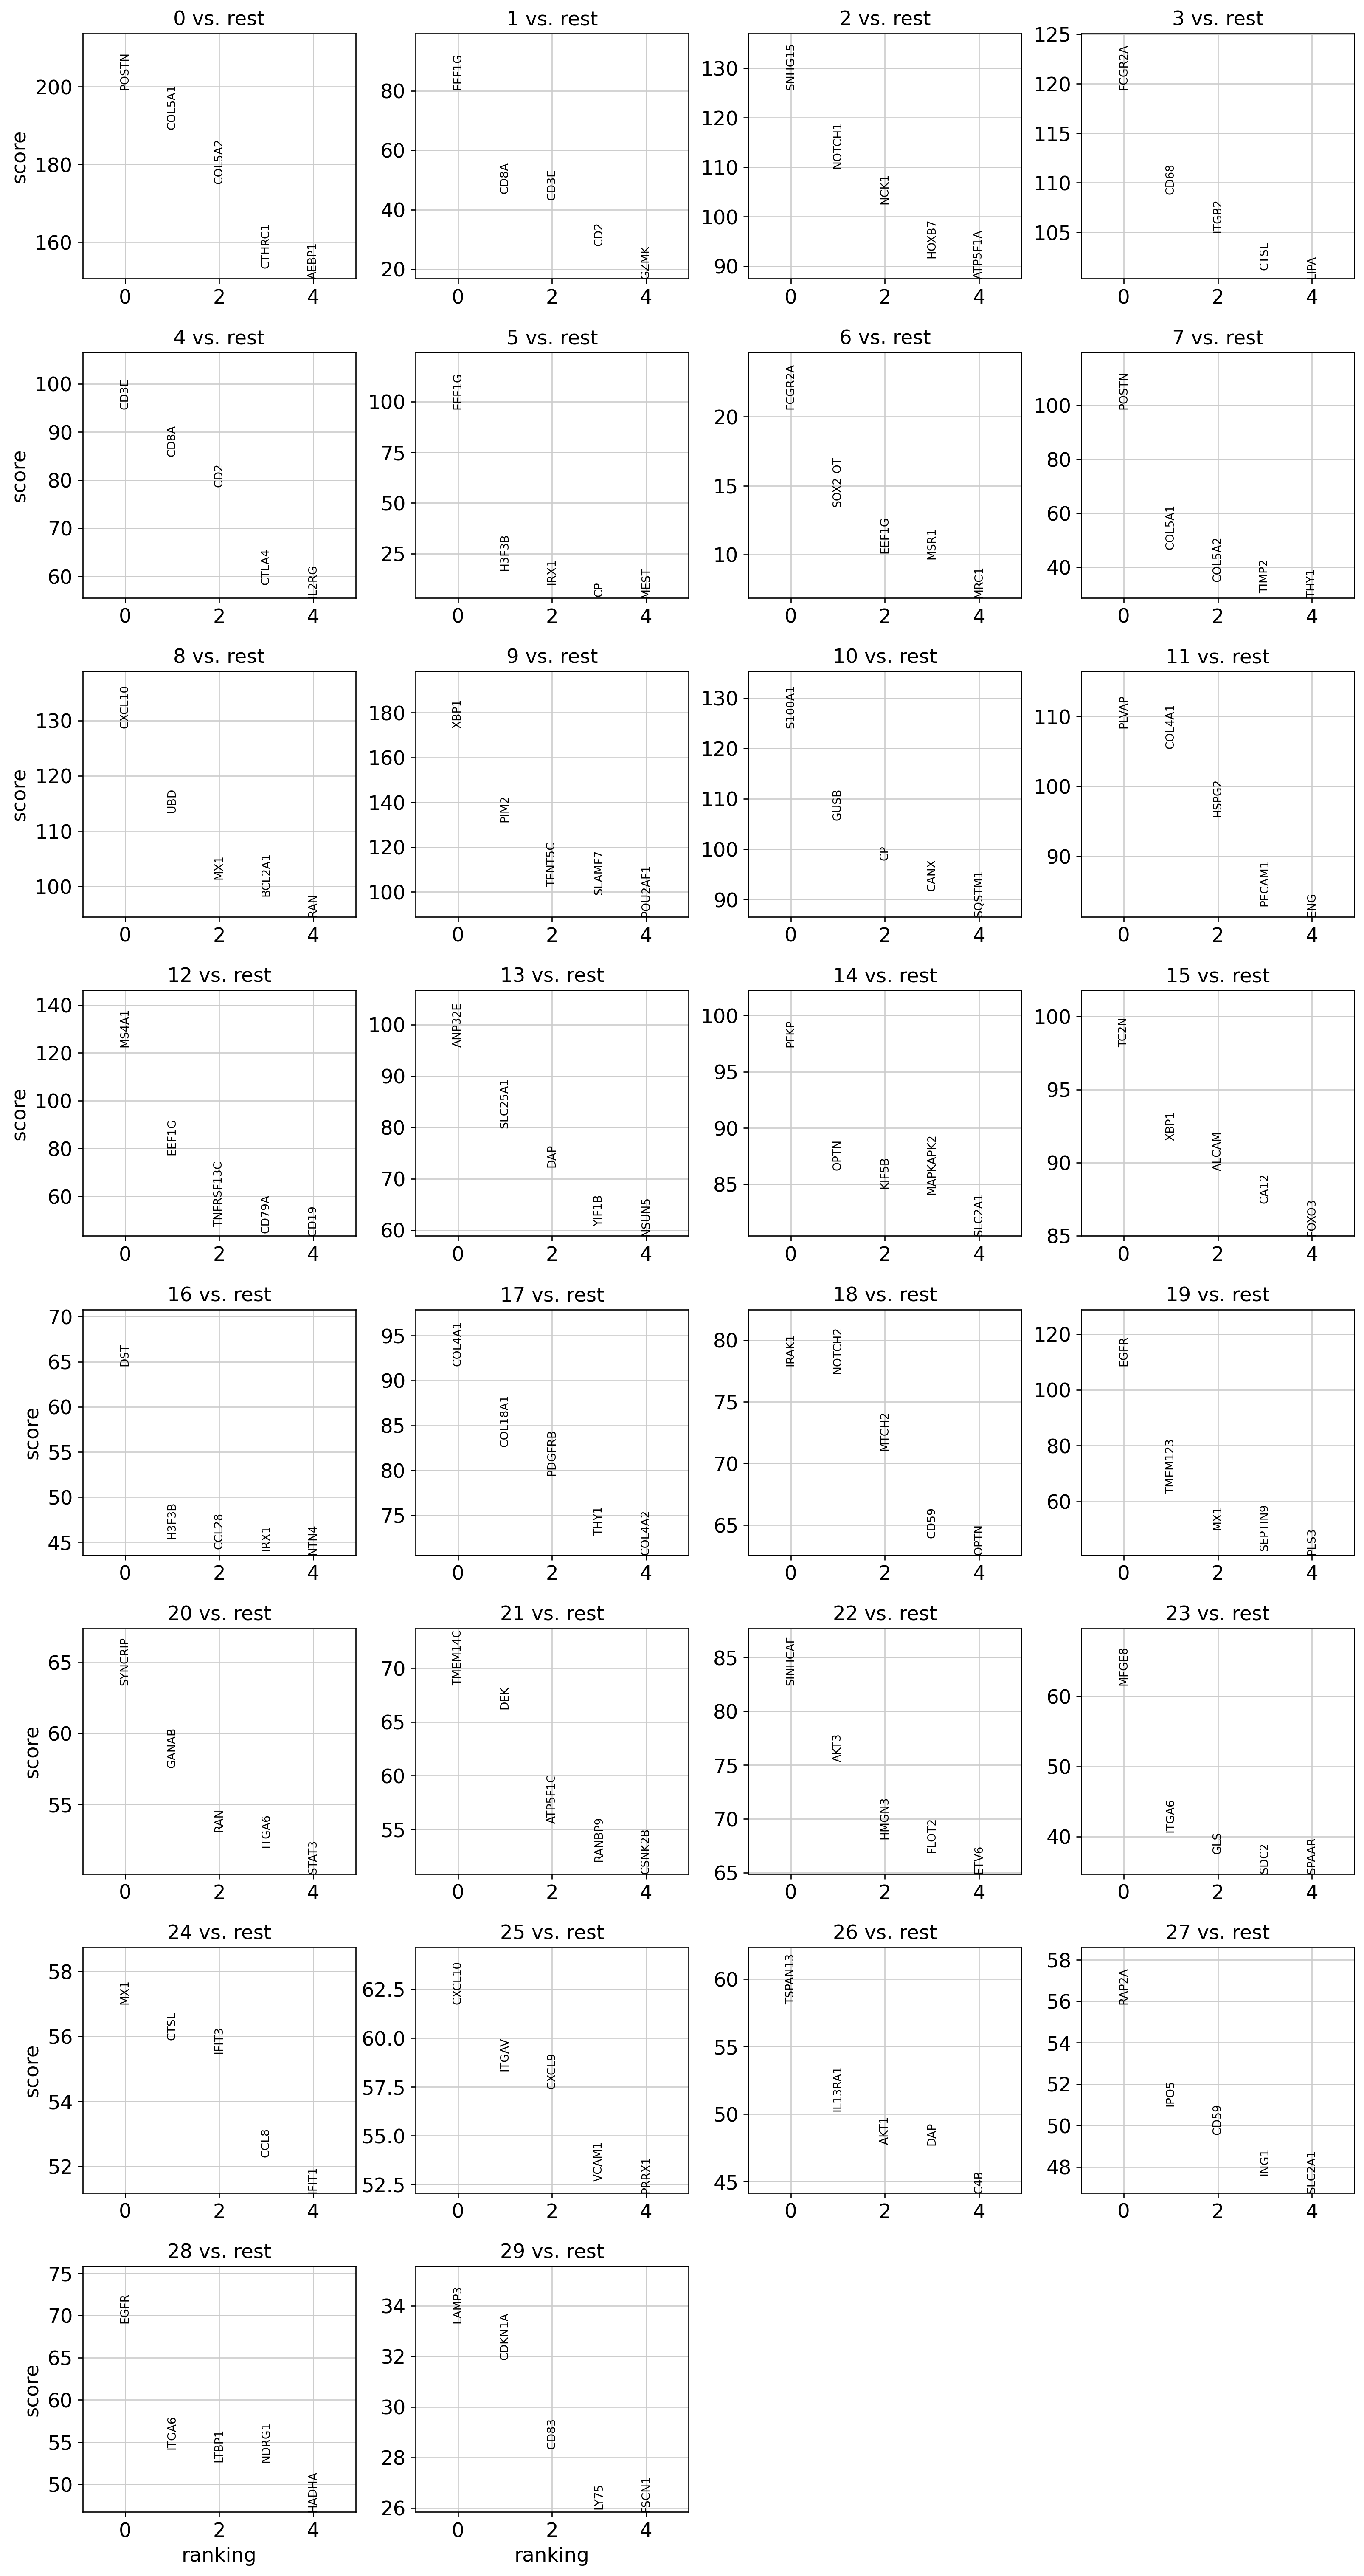

In [19]:
# Marker discovery per cluster
sc.tl.rank_genes_groups(adata, groupby="leiden_1", method="wilcoxon", n_genes=50)
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)


## Marker-driven cell annotation

Adjust the marker lists to your biology. Scores are computed per cell, and the highest-scoring label is kept as a soft annotation that you can refine with the differential expression table above.

Markers kept (present in data): {'Immune_T': ['CD3E'], 'Immune_B': ['MS4A1', 'CD79A', 'CD79B'], 'NK': ['KLRD1'], 'Endothelial': ['PECAM1', 'KDR']}
computing score 'score_Immune_T'
    finished (0:00:03)
computing score 'score_Immune_B'
    finished (0:00:03)
computing score 'score_NK'
    finished (0:00:03)
computing score 'score_Endothelial'
    finished (0:00:03)


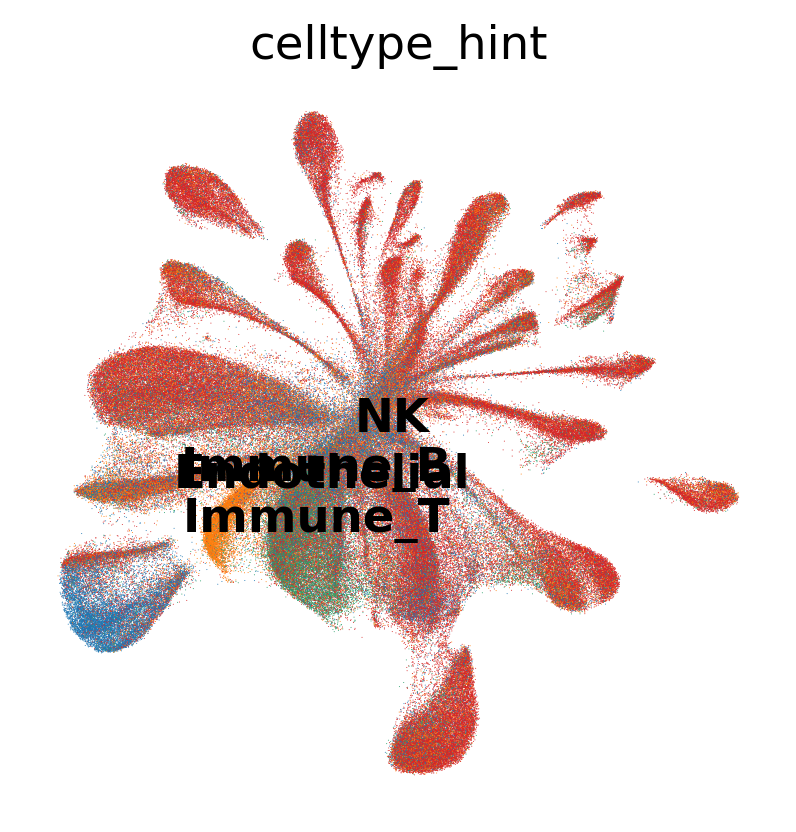

In [20]:
marker_dict = {
    "Epithelial": ["EPCAM", "KRT8", "KRT18"],
    "Immune_T": ["PTPRC", "CD3D", "CD3E", "TRBC1"],
    "Immune_B": ["MS4A1", "CD79A", "CD79B"],
    "NK": ["NKG7", "GNLY", "KLRD1"],
    "Fibroblast": ["COL1A1", "COL1A2", "DCN"],
    "Endothelial": ["PECAM1", "VWF", "KDR"],
    "Proliferating": ["MKI67", "TOP2A", "PCNA"],
}

marker_dict = {k: [g for g in v if g in adata.var_names] for k, v in marker_dict.items()}
marker_dict = {k: v for k, v in marker_dict.items() if len(v) > 0}
print("Markers kept (present in data):", marker_dict)

for label, genes in marker_dict.items():
    sc.tl.score_genes(adata, gene_list=genes, score_name=f"score_{label}")

score_df = pd.DataFrame({k: adata.obs[f"score_{k}"] for k in marker_dict})
adata.obs["celltype_hint"] = score_df.idxmax(axis=1) if not score_df.empty else "NA"

sc.pl.umap(adata, color=["celltype_hint"], legend_loc="on data", frameon=False)


In [1]:
# Spatial overview of clusters and a few marker genes
genes_to_plot = [g for g in ["EPCAM", "PTPRC", "PECAM1", "COL1A1", "MKI67"] if g in adata.var_names][:4]

# ensure scalefactors exist for Xenium fallback (no histology image)
scalef = adata.uns.setdefault("spatial", {}).setdefault(LIB_ID, {}).setdefault("scalefactors", {})
scalef.setdefault("spot_diameter_fullres", 1.0)
scalef.setdefault("tissue_hires_scalef", 1.0)
scalef.setdefault("tissue_lowres_scalef", 1.0)

plot_kwargs = dict(library_id=LIB_ID, library_key="library_id", spatial_key="spatial", scale_factor=1.0)

sq.pl.spatial_scatter(adata, color=["leiden_1"], size=1.2, legend_loc="right", title="Leiden clusters", **plot_kwargs)
if genes_to_plot:
    sq.pl.spatial_scatter(adata, color=genes_to_plot, size=1.0, ncols=2, cmap="magma", **plot_kwargs)


NameError: name 'adata' is not defined

In [ ]:
# Spatial neighbors + neighborhood statistics
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True, n_neigh=12)
sq.gr.nhood_enrichment(adata, cluster_key="leiden_1")
sq.pl.nhood_enrichment(adata, cluster_key="leiden_1")

sq.gr.co_occurrence(adata, cluster_key="leiden_1", library_key="library_id")
sq.pl.co_occurrence(adata, cluster_key="leiden_1", library_key="library_id")


In [ ]:
# Spatial autocorrelation for spatially variable genes
top_genes = list(adata.var_names[:50])
sq.gr.spatial_autocorr(adata, genes=top_genes, mode="moran")
sq.pl.spatial_autocorr(adata, genes=top_genes[:6], mode="moran")


In [ ]:
# Ligand-receptor analysis (requires omnipath download on first run)
try:
    lr = sq.datasets.ligrec()
    sq.gr.ligrec(adata, cluster_key="leiden_1", ligand_receptor=lr)
    sq.pl.ligrec(adata, cluster_key="leiden_1", source_groups=None, target_groups=None, figsize=(6, 6))
except Exception as e:
    print("Ligand-receptor analysis skipped:", e)


In [ ]:
# Save processed object
adata.write("squidpy_xenium_processed.h5ad", compression="gzip")
print("Saved to squidpy_xenium_processed.h5ad")


## Next steps
- Adjust QC filters to your tissue and re-run clustering if needed.
- Tweak marker dictionaries and use `sc.tl.rank_genes_groups` output to refine cell-type labels.
- If you need region-level analyses, create region annotations (e.g., tumor vs. stroma) in `adata.obs` and reuse the spatial stats with that key.
- For high-res visualization, consider loading `morphology.ome.tif` with `sq.im.ImageContainer` and passing it to `sq.pl.spatial_scatter`.
